# Analysis of COVID19 specific T-cell receptors in ImmuneCode Database reveals cross-reactivity to Influenza epitopes

In this jupyter notebook, we will walk through how to generate the results presented in the manuscript by Sidhom & Baras.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scripts.utils import *
import matplotlib
matplotlib.rc('font', family='Arial')

Import data from pre-processed dataframe. Script in utils called Parse_Data.py does the pre-processing from the files provided by Adaptive.

In [4]:
#pull parsed data
data = pd.read_csv('Data/data_parsed.csv')
data['counts'] =  1

In [5]:
data.head()

,beta_sequences,peptide,Experiment,Subject,Cohort,orf,orf_name,counts
0,CASSLRGRLNTEAFF,ADAGFIKQY,eHO124,s_3819,Healthy (No known exposure),KDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQY,surface glycoprotein,1
1,CASSLRGRLNTEAFF,AELEGIQY,eHO124,s_3819,Healthy (No known exposure),ORF1ab,ORF1ab,1
2,CASSLRGRLNTEAFF,LADAGFIKQY,eHO124,s_3819,Healthy (No known exposure),KDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQY,surface glycoprotein,1
3,CASSLRGRLNTEAFF,TLADAGFIK,eHO124,s_3819,Healthy (No known exposure),KDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQY,surface glycoprotein,1
4,CASSLDGLTRSSYNSPLHF,ADAGFIKQY,eHO124,s_3819,Healthy (No known exposure),KDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQY,surface glycoprotein,1


Now we will import data from McPas-TCR, select for human TCRs and map CDR3 sequences to provided known epitopes.

In [7]:
mcpas = pd.read_csv('Data/McPAS-TCR.csv')
mcpas = mcpas[mcpas['Species']=='Human']
path_dict = dict(zip(mcpas['CDR3.beta.aa'],mcpas['Pathology']))
data['Pathology'] = data['beta_sequences'].map(path_dict)
pep_dict = dict(zip(mcpas['CDR3.beta.aa'],mcpas['Epitope.peptide']))
data['Path_Peptide'] = data['beta_sequences'].map(pep_dict)
data.dropna(subset=['Path_Peptide'],inplace=True)

We can now see that every TCR that has a mapping to a known epitope is present.

In [8]:
data.head()

,beta_sequences,peptide,Experiment,Subject,Cohort,orf,orf_name,counts,Pathology,Path_Peptide
313,CASSLLAGGTDTQYF,KPLEFGATSAAL,eOX43,s_19830,Healthy (No known exposure),ORF1ab,ORF1ab,1,Influenza,LPRRSGAAGA
412,CASSPGTAYEQYF,AEIPKEEVKPF,eQD108,s_500001,COVID-19-Convalescent,ORF1ab,ORF1ab,1,Neoantigen,KLWASPLHV
413,CASSPGTAYEQYF,ASKIITLKK,eQD108,s_500001,COVID-19-Convalescent,ATIPIQASLPFGWLIVGVALLAVFQSASKIITLKKRWQ,ORF3a,1,Neoantigen,KLWASPLHV
414,CASSPGTAYEQYF,SASKIITLK,eQD108,s_500001,COVID-19-Convalescent,ATIPIQASLPFGWLIVGVALLAVFQSASKIITLKKRWQ,ORF3a,1,Neoantigen,KLWASPLHV
576,CASSLDGNTEAFF,ILGTVSWNL,eOX43,s_19830,Healthy (No known exposure),ORF1ab,ORF1ab,1,Cytomegalovirus (CMV),FRCPRRFCF


Turn this data from long format to a table via pivot_table.

In [10]:
data_piv = pd.pivot_table(data,index='beta_sequences',columns='Path_Peptide',values='counts',
                             fill_value=0.0,aggfunc='max')

In [11]:
data_piv

Path_Peptide,ALIHHNTHL,ALYGFVPVL,CRVLCCYVL,EAAGIGILTV,ELAGIGILTV,FLFMYLVTV,FLIYLDVSV,FLNVLFPLL,FLYNPLTRV,FPRPWLHGL,...,PQPELPYPQPE,PQPELPYPQPQ,RPHERNGFTVL,RYPLTFGWCF,TPRVTGGGAM,VLLGVKLFGV,VVMSWAPPV,VVTGVLVYL,YLEPGPVTA,YVLTWIVGA
beta_sequences,,,,,,,,,,,,,,,,,,,,,
CAISESYEQYF,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
CASSAGGGSYNEQFF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CASSAGGSYEQYF,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CASSAGSYGYTF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CASSAGTAYNEQFF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CASSWGRTYEQYF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CASSYDRSYEQYF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
CASSYGQGYEQYF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We can then cluster the columns and show our clustermap.

[]

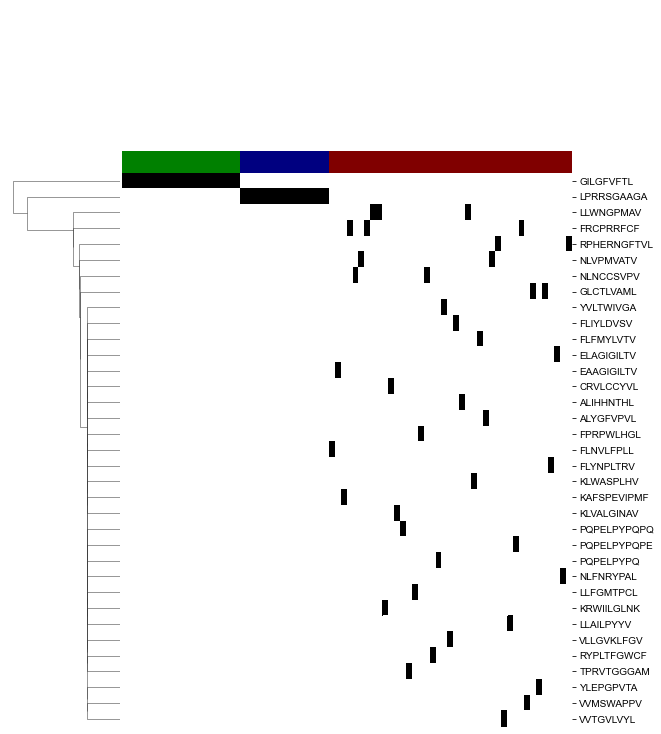

In [12]:
X = np.array(data_piv)
idx = KMeans(n_clusters=3,random_state=2).fit_predict(X)
color_dict = Get_Color_Dict(idx)
col_colors = [color_dict[x] for x in idx]
data_piv_sort = data_piv.iloc[np.flip(np.argsort(idx))]
col_colors = np.array(col_colors)[np.flip(np.argsort(idx))]

CM = sns.clustermap(data=data_piv_sort.T,cmap='binary',col_cluster=False,col_colors=col_colors)
ax = CM.ax_heatmap
CM.cax.set_visible(False)
ax.set_xticklabels('')
plt.subplots_adjust(right=0.8,top=1.1,bottom=0.1)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])

Creates separate dataframes for each cluster above.

In [13]:
DFs = []
for cl in np.unique(idx):
    tcr = data_piv.index[idx == cl]
    DFs.append(data[data['beta_sequences'].isin(tcr)])

Cluster 2 represents the GILGFVFTL epitope.

In [15]:
DFs[2].head()

,beta_sequences,peptide,Experiment,Subject,Cohort,orf,orf_name,counts,Pathology,Path_Peptide
1125,CASSQDPGYEQYF,FLNGSCGSV,eOX43,s_19830,Healthy (No known exposure),ORF1ab,ORF1ab,1,Influenza,GILGFVFTL
1408,CASSPGTDIYEQYF,FLNRFTTTL,eOX43,s_19830,Healthy (No known exposure),ORF1ab,ORF1ab,1,Influenza,GILGFVFTL
2088,CASSLEVGQETQYF,RQLLFVVEV,eOX43,s_19830,Healthy (No known exposure),ORF1ab,ORF1ab,1,Influenza,GILGFVFTL
2744,CASSLSSYNEQFF,APAHISTI,eOX43,s_19830,Healthy (No known exposure),ORF1ab,ORF1ab,1,Influenza,GILGFVFTL
2745,CASSLSSYNEQFF,LIVNSVLLFL,eOX43,s_19830,Healthy (No known exposure),MYSFVSEETGTLIVNSVLLFLAFVVFLLVTLAILTALRL,envelope,1,Influenza,GILGFVFTL


We can then tabulate the number of unique TCRs for each ORF/peptide pair across all individuals and visualize this. 

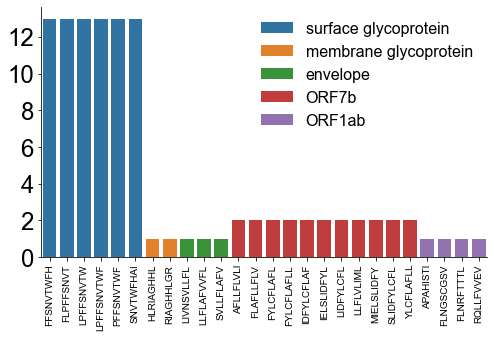

In [16]:
cluster_sel = 2
df_agg = DFs[cluster_sel].groupby(['peptide', 'orf_name']).agg({'counts': 'sum'}).reset_index()
df_agg.sort_values(by=['orf_name','peptide'],inplace=True,ascending=[False,True])
BarPlot(df_agg)

And then we can look at the seqlogo for the TCRs reactive to the surface glycoprotein epitopes.

/home/jsidhom1/COVID19/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


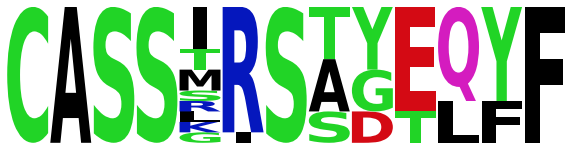

In [17]:
DFs[cluster_sel].sort_values(by=['orf_name','peptide'],inplace=True,ascending=[False,True])
df_sel = DFs[cluster_sel][DFs[cluster_sel]['peptide'].isin(df_agg['peptide'].iloc[0:5])]
sel_seq = np.unique(df_sel['beta_sequences'])
ax = Make_Logo(sel_seq)

Finally, we can look at how these unique TCRs are distributed in different individuals, stratified by COVID19 exposed vs non-exposed.

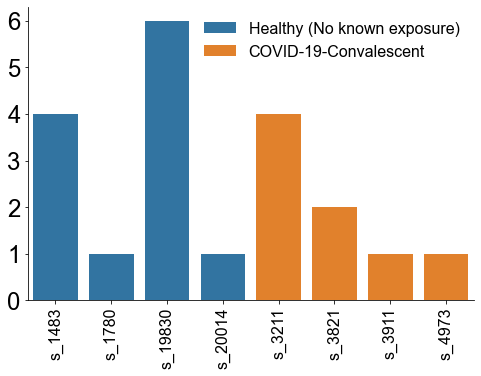

In [18]:
df_agg = DFs[cluster_sel].drop_duplicates(subset=['beta_sequences', 'Subject'])
df_agg = df_agg.groupby(['Subject']).agg({'Cohort': 'first', 'counts': 'sum'}).reset_index()
BarPlotCohort(df_agg)

We can repeat these same steps above to generate comparable results for LPRRSGAAGA.

/home/jsidhom1/COVID19/venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


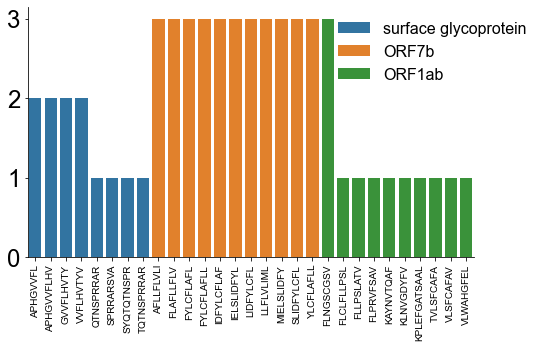

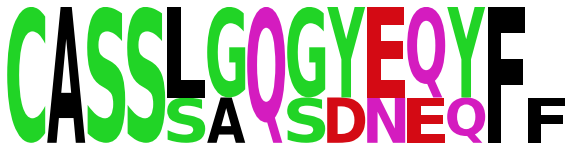

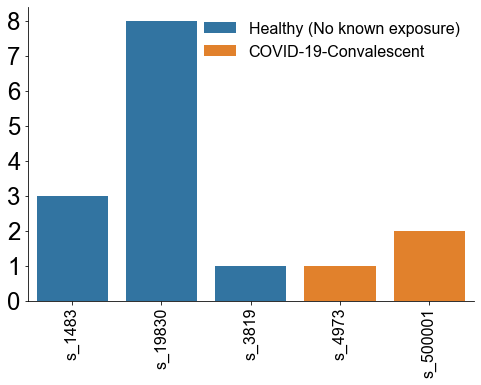

In [19]:
cluster_sel = 1
df_agg = DFs[cluster_sel].groupby(['peptide', 'orf_name']).agg({'counts': 'sum'}).reset_index()
df_agg.sort_values(by=['orf_name','peptide'],inplace=True,ascending=[False,True])
df_agg.reset_index(drop=True,inplace=True)
leg = BarPlot(df_agg)
bbox_to_anchor=[1.15, 1]
leg.set_bbox_to_anchor(bbox_to_anchor)

DFs[cluster_sel].sort_values(by=['orf_name','peptide'],inplace=True,ascending=[False,True])
sel = [0,1,2,7]
df_sel = DFs[cluster_sel][DFs[cluster_sel]['peptide'].isin(df_agg['peptide'].iloc[sel])]
sel_seq = np.unique(df_sel['beta_sequences'])
ax = Make_Logo(sel_seq)

df_agg = DFs[cluster_sel].drop_duplicates(subset=['beta_sequences','Subject'])
df_agg = df_agg.groupby(['Subject']).agg({'Cohort':'first','counts':'sum'}).reset_index()
BarPlotCohort(df_agg)